# Tara Sequencer

In [1]:
# imports
from importlib import reload
import numpy as np
import pandas
import datetime

from matplotlib import pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy

import seaborn as sns

from oceancolor.tara import io
from oceancolor.tara import spectra

import sequencer
from sequencer import sequencer_

# Load the Table

In [2]:
tara_db = io.load_tara_db()

# Process the spectra

In [3]:
reload(spectra)
wv_nm, all_a_ph, all_a_ph_sig = spectra.spectra_from_table(tara_db)
wv_grid = np.arange(402.5, 707.5, 5.)
rwv_nm, r_aph, r_sig = spectra.rebin_to_grid(wv_nm, all_a_ph, all_a_ph_sig, wv_grid)

/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/spectra.py:248: RuntimeWarning: invalid value encountered in divide
  isum = np.nansum(values[gd]*mask[gd], axis=0) / np.sum(mask[gd],axis=0)
/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/spectra.py:249: RuntimeWarning: invalid value encountered in divide
  esum = np.nansum(err_vals[gd]*mask[gd], axis=0) / np.sum(mask[gd],axis=0)


In [4]:
r_aph.shape

(302779, 60)

# Remove bad spectra

In [5]:
tot_spec = np.nansum(r_aph, axis=-1)
gd_tot = tot_spec > 0.

## cut

In [40]:
cull_raph = r_aph[gd_tot, :]
cull_rsig = r_sig[gd_tot, :]

# Deal with NaN

In [41]:
bad = np.isnan(cull_raph) | (cull_rsig <= 0.) | (cull_raph <0.)
print(f'Nbad = {np.sum(bad)}')
# Replace
cull_raph[bad] = 1e-4
cull_rsig[bad] = 1e5

Nbad = 81851


# Start with a random set of spectra

In [42]:
rand = np.random.choice(np.arange(cull_raph.shape[0]), size=100, replace=False)
rand_raph = cull_raph[rand,:]

# Init the Sequencer

In [43]:
reload(sequencer_)
grid = np.arange(len(rwv_nm))
estimator_list = ['EMD', 'energy', 'L2'] # Removed KL because of the 0 values
seq = sequencer.Sequencer(grid, rand_raph, estimator_list)

# Run it

## Output directory

In [44]:
# to execute the sequencer, we first need to define the output directory to which the different 
# outputs will be saved
output_path = "/home/xavier/Projects/Oceanography/Color/Sequencer/Tara"
final_elongation, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 0.2845947742462158 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 0.5106456279754639 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 0.2752563953399658 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 0.5236868858337402 seconds
calculating the distance matrices for estimator: L2, scale: 1
finished calculating this distance matrix list, it took: 0.02348160743713379 seconds
calculating the distance matrices for estimator: L2, scale: 2
finished calculating this distance matrix list, it took: 0.04540896415710449 seconds
dumped the distance matrix dictionaries to the file: /home/xavier/Projects/Oceanography/Color/Sequencer/Tara/dis

# Explore

In [45]:
# print the resulting elongation
print("resulting elongation: ", final_elongation)


# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()


print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   np.round(elongation_list[i], 2)))


resulting elongation:  6.9386
intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 11.94
metric=EMD, scale=2, elongation: 22.73
metric=energy, scale=1, elongation: 10.62
metric=energy, scale=2, elongation: 18.34
metric=L2, scale=1, elongation: 5.77
metric=L2, scale=2, elongation: 12.79


In [35]:
final_sequence

array([11, 40, 30, 47, 24, 72, 87, 76, 99, 28, 59, 10, 43, 65, 66, 20,  3,
       93, 88, 37, 89, 54, 26, 17, 19,  7, 35,  2, 62, 91, 85, 71, 75, 67,
       63, 55, 13, 42,  6, 22, 82, 45, 58,  5, 23, 44, 81, 86, 31, 69, 95,
       79, 34,  4, 80, 29, 12, 64, 32, 25, 83,  8, 70, 18, 49, 50, 74, 21,
       94, 77, 56, 53,  9, 36, 48, 38, 73, 46, 98, 60, 97, 51, 39, 41,  1,
       33, 84, 14, 27, 15, 90, 57, 96, 78, 52,  0, 16, 92, 68, 61])

In [36]:
rand_raph.shape

(100, 60)

Text(0, 0.5, 'object index')

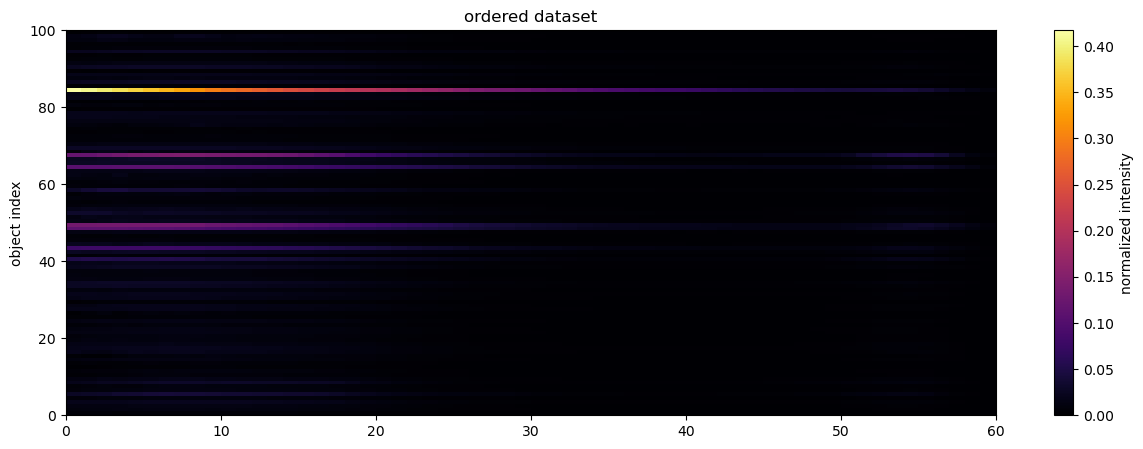

In [46]:
# plot the ordered dataset
reorder_raph = rand_raph[final_sequence, :]

plt.figure(1, figsize=(15, 5))
plt.title("ordered dataset")
#plt.pcolormesh(rand_raph, cmap="inferno")
plt.pcolormesh(reorder_raph, cmap="inferno")
plt.colorbar(label="normalized intensity")
plt.ylabel("x")
plt.ylabel("object index")

Text(0, 0.5, 'object index')

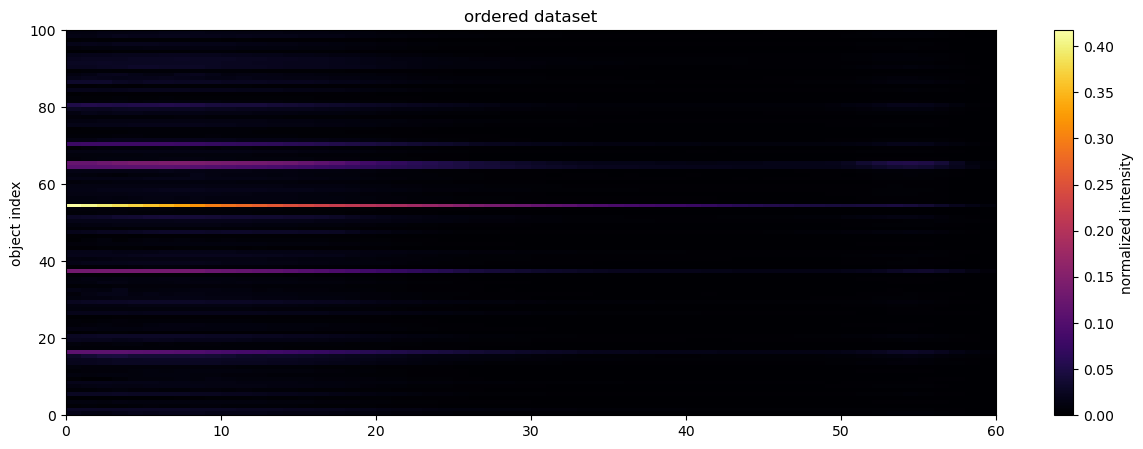

In [47]:
# plot the ordered dataset
#reorder_raph = rand_raph[final_sequence, :]

plt.figure(1, figsize=(15, 5))
plt.title("ordered dataset")
plt.pcolormesh(rand_raph, cmap="inferno")
#plt.pcolormesh(reorder_raph, cmap="inferno")
plt.colorbar(label="normalized intensity")
plt.ylabel("x")
plt.ylabel("object index")

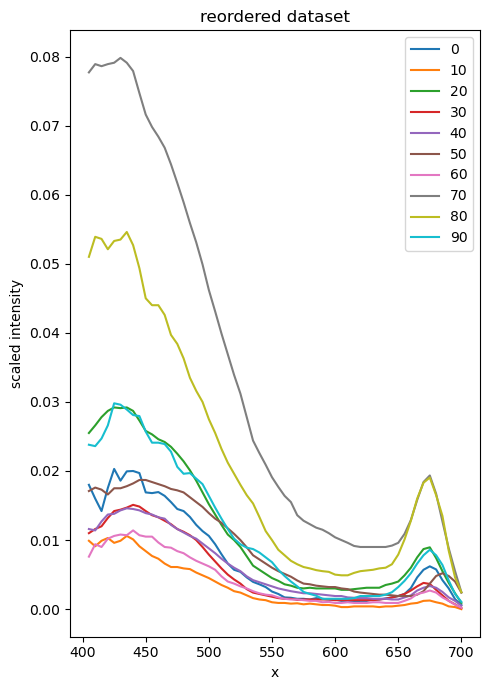

In [49]:
plt.figure(1, figsize=(5, 7))
plt.title("reordered dataset")
ax = plt.gca()
for ii in range(0,len(final_sequence),10):
    #object_data_scaled_y = object_data + i*1.5 # scale the objects so they will not be one on top of the other
    ax.plot(rwv_nm, rand_raph[ii,:], label=f'{ii}')#, "k")
    
plt.xlabel("x")
plt.ylabel("scaled intensity")
ax.legend()
plt.tight_layout()
plt.show()

----

# Debuggin

In [23]:
norm = np.sum(r_aph, axis=-1)
norm.size

302779

In [25]:
bad = norm <= 0.
np.sum(bad)

15